## Analytical results analysis

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import FormatStrFormatter

import logging
import os
import math
import multiprocessing
import json
import re

from scipy.stats import t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import natsort

ModuleNotFoundError: No module named 'natsort'

In [ ]:
use_markers = False
experiment_type = "cv2x"

use_line_types = False
image_format = "png"
figure_store = "../data/figures/"

markers = [".", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+",
           "x", "X", "D", "d", "|", "_", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

overall_now="12:00:00"
confidence_intervals = False

### Graphing

In [ ]:
def distance_graph(folders, graph, comparison, configurations, now):
    means = []
    cis = []
    distances = []
    for folder, config in zip(folders, configurations):
        df = pd.read_csv("{}/{}.csv".format(folder, graph))
        means.append(list(df["Mean"]))
        if confidence_intervals:
            cis.append(list(df["Confidence-Interval"]))
        distances = (list(range(0, df.shape[0] * 10, 10)))

    if graph in ["PDR-SCI", "PDR-TB"]:
        dist_graph(means, distances, configurations,
                   "{}-{}".format(comparison, graph), ylabel="Packet Delivery Rate %", now=now,
                    confidence_intervals=cis, show=False, store=True, percentage=True)
    elif graph == "IPG":
        dist_graph(means, distances, configurations,
                   "{}-{}".format(comparison, graph), ylabel="Inter-Packet Gap (ms)", now=now,
                   legend_pos="upper left", confidence_intervals=cis, show=False, store=True)

In [ ]:
def cbr_graph(folders, graph, comparison, configurations, now):
    # Might change this to time based graph but CBR is fine for now
    times = []
    cbr = []
    cis = []
    for folder, config in zip(folders, configurations):
        df = pd.read_csv("{}/CBR.csv".format(folder))
        times.append(list(df["Time"]))
        cbr.append(list(df["Mean"]))
        if confidence_intervals:
            cis.append(list(df["Confidence-Interval"]))

    cbr_plot(cbr, times, "{}-{}".format(comparison, graph), configurations, now=now,
             confidence_intervals=cis, show=False, store=True)

In [ ]:
def dist_graph(means, distances, labels, plot_name, ylabel, now, legend_pos="lower left",
               confidence_intervals=None, show=True, store=False, percentage=False):
    fig, ax = plt.subplots()

    for i in range(len(means)):
        if confidence_intervals:
            ax.errorbar(distances, means[i], yerr=confidence_intervals[i], label=labels[i])
        else:
            ax.plot(distances, means[i], label=labels[i])

    ax.set(xlabel='Distance (m)', ylabel=ylabel)
    ax.legend(loc=legend_pos)
    ax.tick_params(direction='in')

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    if percentage:
        ax.set_ylim([0, 100])
        plt.yticks(np.arange(0, 101, step=10))

    if show:
        fig.show()

    if store:
        fig.savefig("{}/{}-{}.png".format(figure_store, plot_name, now), dpi=300)
    plt.close(fig)

In [ ]:
def cbr_plot(cbr, times, plot_name, labels, now, confidence_intervals=None, show=True, store=False):
    fig, ax = plt.subplots()

    for i in range(len(cbr)):
        if confidence_intervals:
            ax.errorbar(times[i], cbr[i], yerr=confidence_intervals[i], label=labels[i])
        else:
            ax.plot(times[i], cbr[i], label=labels[i])

    ax.legend(loc='upper left')
    ax.set(xlabel='Time (s)', ylabel='Channel Busy Ratio %')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))

    if show:
        fig.show()

    if store:
        fig.savefig("{}/{}-{}.png".format(figure_store, plot_name, now), dpi=300)
    plt.close(fig)

### Setup

In [ ]:
confidence_intervals = None
show = True
store = False
percentage = True

In [ ]:
np.arange(0, 500 + 25, 25)

In [ ]:
omnet_analytical = {
    "mcs7" : {
        "01vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs7/7MCS_20dBm_01vpm/PDR-TB.csv",
            "23dbm": "/hdd/results-analysis/data/processed_data/mcs7/7MCS_23dBm_01vpm-2020-02-28-16_47_32/PDR-TB.csv"
        },
        "02vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs7/7MCS_20dBm_02vpm/PDR-TB.csv",
            "23dbm": None
        },
        "03vpm": {
            "20dbm": None,
            "23dbm": None
        }
    },
    "mcs9" : {
        "01vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs9/9MCS_20dBm_01vpm/PDR-TB.csv",
            "23dbm": "/hdd/results-analysis/data/processed_data/mcs9/9MCS_23dBm_01vpm-2020-02-28-16_48_32/PDR-TB.csv"
        },
        "02vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs9/9MCS_20dBm_02vpm/PDR-TB.csv",
            "23dbm": None
        },
        "03vpm": {
            "20dbm": None,
            "23dbm": None
        }
    },
}

In [ ]:
matlab_analytical = {
    "mcs7" : {
        "01vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs7/01vpm-7mcs-20dbm.csv",
            "23dbm": "/hdd/results-analysis/data/processed_data/mcs7/01vpm-7mcs-23dbm.csv"
        },
        "02vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs7/02vpm-7mcs-20dbm.csv",
            "23dbm": "/hdd/results-analysis/data/processed_data/mcs7/02vpm-7mcs-23dbm.csv"
        },
        "03vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs7/03vpm-7mcs-20dbm.csv",
            "23dbm": "/hdd/results-analysis/data/processed_data/mcs7/03vpm-7mcs-23dbm.csv"
        }
    },
    "mcs9" : {
        "01vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs9/01vpm-9mcs-20dbm.csv",
            "23dbm": "/hdd/results-analysis/data/processed_data/mcs9/02vpm-9mcs-23dbm.csv"
        },
        "02vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs9/02vpm-9mcs-20dbm.csv",
            "23dbm": "/hdd/results-analysis/data/processed_data/mcs9/02vpm-9mcs-23dbm.csv"
        },
        "03vpm": {
            "20dbm": "/hdd/results-analysis/data/processed_data/mcs9/03vpm-9mcs-20dbm.csv",
            "23dbm": "/hdd/results-analysis/data/processed_data/mcs9/03vpm-9mcs-23dbm.csv"
        }
    },
}

In [ ]:
omnet_dfs = {}
for modulation in omnet_analytical:
    omnet_dfs[modulation] = {}
    
    for density in omnet_analytical[modulation]:
        omnet_dfs[modulation][density] = {}
        
        for power in omnet_analytical[modulation][density]:
            
            if omnet_analytical[modulation][density][power]:
                df = pd.read_csv(omnet_analytical[modulation][density][power])
                df = df[0:21]
                
                omnet_dfs[modulation][density][power] = df
            else:
                omnet_dfs[modulation][density][power] = None

In [ ]:
matlab_dfs = {}
for modulation in matlab_analytical:
    matlab_dfs[modulation] = {}
    
    for density in matlab_analytical[modulation]:
        matlab_dfs[modulation][density] = {}
        
        for power in matlab_analytical[modulation][density]:
            
            if matlab_analytical[modulation][density][power]:
                df = pd.read_csv(matlab_analytical[modulation][density][power])
                df["pdr"] = df["pdr"].multiply(100)
                
                matlab_dfs[modulation][density][power] = df
            else:
                matlab_dfs[modulation][density][power] = None

In [2]:
distances = [x for x in range(0, 525, 25)]

In [3]:
show = True
store = False

In [4]:
for modulation in matlab_analytical:
    for density in matlab_analytical[modulation]:
        for power in matlab_analytical[modulation][density]:
            if omnet_analytical[modulation][density][power] and matlab_analytical[modulation][density][power]:
            
                fig, ax = plt.subplots()

                ax.plot(distances, omnet_dfs[modulation][density][power]["Mean"], label="Simulation")
                ax.plot(distances, matlab_dfs[modulation][density][power]["pdr"], label="Analytical")

                ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate %')
                ax.legend(loc='lower left')
                ax.tick_params(direction='in')

                ax.set_xlim([0, 501])
                plt.xticks(np.arange(0, 501, step=50))

                ax.set_ylim([0, 100])
                plt.yticks(np.arange(0, 101, step=10))

                fig.savefig("../data/figures/Validation-{}-{}-{}.png".format(modulation,density,power), dpi=300)

                plt.close(fig)

NameError: name 'matlab_analytical' is not defined

NameError: name 'omnet_dfs' is not defined

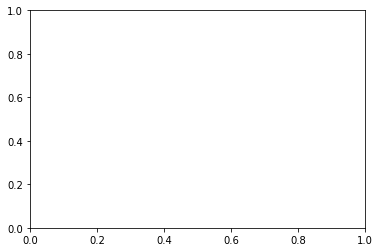

In [5]:
fig, ax = plt.subplots()

ax.plot(distances, omnet_dfs["mcs7"]["01vpm"]["23dbm"]["Mean"], label="Simulation")
ax.plot(distances, omnet_dfs["mcs7"]["01vpm"]["20dbm"]["Mean"], label="Sim2")

ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate %')
ax.legend(loc='lower left')
ax.tick_params(direction='in')

ax.set_xlim([0, 501])
plt.xticks(np.arange(0, 501, step=50))

ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 101, step=10))

plt.show()

plt.close(fig)

In [6]:
df = pd.read_csv("/Users/brianmccarthy/git_repos/results-analysis/data/processed_data/cv2x/9MCS_23dBm_01vpm-2020-03-02-12_09_52/PDR-TB.csv")

In [11]:
mcs7 = pd.read_csv("/Users/brianmccarthy/git_repos/results-analysis/data/processed_data/mcs7/MCS7-20dBm-01vpm/PDR-TB.csv")

In [9]:
distances = [x for x in range(0, 500, 10)]

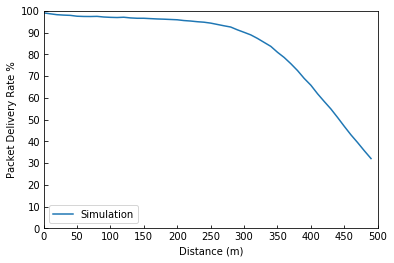

In [14]:
fig, ax = plt.subplots()

ax.plot(distances, df["Mean"], label="Simulation")

ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate %')
ax.legend(loc='lower left')
ax.tick_params(direction='in')

ax.set_xlim([0, 501])
plt.xticks(np.arange(0, 501, step=50))

ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 101, step=10))

plt.show()

fig.savefig("../data/figures/Validation-{}-{}-{}.png".format("MCS9","01vpm","23dBm"), dpi=300)

plt.close(fig)

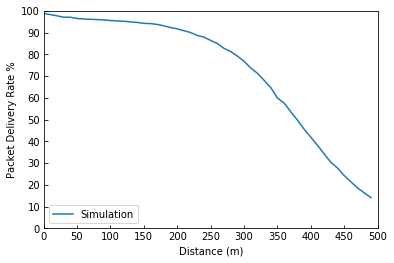

In [13]:
fig, ax = plt.subplots()

ax.plot(distances, mcs7["Mean"], label="Simulation")

ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate %')
ax.legend(loc='lower left')
ax.tick_params(direction='in')

ax.set_xlim([0, 501])
plt.xticks(np.arange(0, 501, step=50))

ax.set_ylim([0, 100])
plt.yticks(np.arange(0, 101, step=10))

plt.show()

fig.savefig("../data/figures/Validation-{}-{}-{}.png".format("MCS7","01vpm","20dBm"), dpi=300)

plt.close(fig)